In [ ]:
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
import numpy as np                 # for algebric functions
import matplotlib.pyplot as plt    # to plot graph
import torchvision
import torch.optim as optim
import copy
import random
import time
import gc
import pickle
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

torch.set_default_tensor_type('torch.cuda.FloatTensor')
dtype = dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")
print("Device :", device)

Device : cuda:0


In [ ]:
#Hyperparams
num_clients = 100
label_to_clients = 100
gamma = 0.5
decay = 0.95
update_decay = 0.99
batch_size = 50
num_epochs = 20
lr = 0.01
mnist = False

In [ ]:
if mnist:
  trainset = torchvision.datasets.MNIST(train=True,download=True,root= "./mnist",
                                      transform= torchvision.transforms.ToTensor())
  testset = torchvision.datasets.MNIST(train=False,download=True,root= "./mnist",
                                      transform= torchvision.transforms.ToTensor())
  print(len(trainset))
  print(len(testset))
else:
    trainset = torchvision.datasets.CIFAR10(train=True,download=True,root= "./cifar",
                                      transform= torchvision.transforms.ToTensor())
    testset = torchvision.datasets.CIFAR10(train=False,download=True,root= "./cifar",
                                        transform= torchvision.transforms.ToTensor())
    print(len(trainset))
    print(len(testset))


Files already downloaded and verified
Files already downloaded and verified
50000
10000


# Making the data skewed randomly

In [ ]:
targs = np.array(trainset.targets)
idx = {}
idx_val = {}
for i in range(10):
    idx[i] = np.where(targs == i)[0]
    print(len(idx[i]))

5000
5000
5000
5000
5000
5000
5000
5000
5000
5000


# Let each class be present in $label_to_clients clients, clients chosen randomly

In [ ]:
cmap = {}
data = {}
vald = {}
for i in range(num_clients):
    data[i] = []
    vald[i] = []

#Data from the skew notebook

#highly non-iid data

# client_num = 0
# i = 0
# while i < 10:
#     cmap[i] = []
#     cmap[i+1] = []
#     for j in range((2 * num_clients)//10):
#         cmap[i].append(client_num)
#         if i < 9 :
#             cmap[i + 1].append(client_num)
#         client_num += 1
#     i += 2

#iid data
for i in range(10):
    cmap[i] = []
    for j in range(num_clients):
        cmap[i].append(j)

for i in range(10):
    print (cmap[i])

for i in range(10):
    split = int(np.floor(1/label_to_clients * len(idx[i])))
    for j in range(label_to_clients):
        data[cmap[i][j]].extend(idx[i][j * split : (j + 1) * split])
for i in range(num_clients):
    np.random.shuffle(data[i])
    data[i], vald[i] = data[i][ : (int)(0.9 *len(data[i]))], data[i][(int)(0.9 * len(data[i])) : ]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,

In [ ]:
freq = []

for i in range(num_clients):
    unique, counts = np.unique(np.array(targs[data[i]]), return_counts= True)
    print("Client ", i, " : ")
    print(np.asarray((unique, counts)).T)
    freq.append(np.sum(counts)/len(trainset))
    unique, counts = np.unique(np.array(targs[vald[i]]), return_counts= True)
    print("Val Client ", i, " : ")
    print(np.asarray((unique, counts)).T)
print("Percentage of points in the clients : ", freq)

Client  0  : 
[[ 0 48]
 [ 1 45]
 [ 2 44]
 [ 3 47]
 [ 4 43]
 [ 5 44]
 [ 6 47]
 [ 7 44]
 [ 8 42]
 [ 9 46]]
Val Client  0  : 
[[0 2]
 [1 5]
 [2 6]
 [3 3]
 [4 7]
 [5 6]
 [6 3]
 [7 6]
 [8 8]
 [9 4]]
Client  1  : 
[[ 0 46]
 [ 1 47]
 [ 2 45]
 [ 3 46]
 [ 4 47]
 [ 5 47]
 [ 6 42]
 [ 7 45]
 [ 8 43]
 [ 9 42]]
Val Client  1  : 
[[0 4]
 [1 3]
 [2 5]
 [3 4]
 [4 3]
 [5 3]
 [6 8]
 [7 5]
 [8 7]
 [9 8]]
Client  2  : 
[[ 0 46]
 [ 1 44]
 [ 2 42]
 [ 3 45]
 [ 4 46]
 [ 5 46]
 [ 6 46]
 [ 7 44]
 [ 8 45]
 [ 9 46]]
Val Client  2  : 
[[0 4]
 [1 6]
 [2 8]
 [3 5]
 [4 4]
 [5 4]
 [6 4]
 [7 6]
 [8 5]
 [9 4]]
Client  3  : 
[[ 0 46]
 [ 1 46]
 [ 2 42]
 [ 3 41]
 [ 4 45]
 [ 5 44]
 [ 6 47]
 [ 7 48]
 [ 8 48]
 [ 9 43]]
Val Client  3  : 
[[0 4]
 [1 4]
 [2 8]
 [3 9]
 [4 5]
 [5 6]
 [6 3]
 [7 2]
 [8 2]
 [9 7]]
Client  4  : 
[[ 0 42]
 [ 1 40]
 [ 2 47]
 [ 3 48]
 [ 4 47]
 [ 5 43]
 [ 6 44]
 [ 7 45]
 [ 8 47]
 [ 9 47]]
Val Client  4  : 
[[ 0  8]
 [ 1 10]
 [ 2  3]
 [ 3  2]
 [ 4  3]
 [ 5  7]
 [ 6  6]
 [ 7  5]
 [ 8  3]
 [ 9  3]]
Client  5 

In [ ]:
if mnist : 
  avg_model = nn.Sequential(
          nn.Conv2d(kernel_size=5, out_channels=32, in_channels=1),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(kernel_size=5, out_channels=64, in_channels=32),
          nn.MaxPool2d(kernel_size=2),
          nn.Flatten(),
          nn.Linear(in_features=1024, out_features=512),
          nn.ReLU(),
          nn.Linear(in_features=512, out_features=10),
          nn.Softmax(dim=1)
  ).to(device)

  from torchsummary import summary
  summary(avg_model, (1, 28, 28))
else:
  avg_model = nn.Sequential(
          nn.Conv2d(kernel_size=3, out_channels=32, in_channels=3),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(kernel_size=3, out_channels=64, in_channels=32),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
          nn.Conv2d(kernel_size=3, out_channels=64, in_channels=64),
          nn.Flatten(),
          nn.Linear(in_features=1024, out_features=64),
          nn.ReLU(),
          nn.Linear(64, 10)
  ).to(device)

  from torchsummary import summary
  summary(avg_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
              ReLU-2           [-1, 32, 30, 30]               0
         MaxPool2d-3           [-1, 32, 15, 15]               0
            Conv2d-4           [-1, 64, 13, 13]          18,496
              ReLU-5           [-1, 64, 13, 13]               0
         MaxPool2d-6             [-1, 64, 6, 6]               0
            Conv2d-7             [-1, 64, 4, 4]          36,928
           Flatten-8                 [-1, 1024]               0
            Linear-9                   [-1, 64]          65,600
             ReLU-10                   [-1, 64]               0
           Linear-11                   [-1, 10]             650
Total params: 122,570
Trainable params: 122,570
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
client_models = []
timestamp = []
for i in range(num_clients):
    client_models.append(copy.deepcopy(avg_model))
    timestamp.append(0)
criterion = nn.CrossEntropyLoss()
server_updates = 1
train_accuracy = 0
test_accuracy = 0
testdata = torch.utils.data.DataLoader(dataset=testset, batch_size=512)
for iter, batch in enumerate(testdata):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = avg_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct_pred = predicted.eq(labels.data).sum().item()
        test_accuracy = test_accuracy + (correct_pred/512) * 100
        del inputs, labels, outputs, correct_pred, predicted
init_serv_test_acc = test_accuracy * 512/len(testset)
print("Initial server test accuracy ", init_serv_test_acc)


Initial server test accuracy  10.09


Client  62  has started training with batch size  50  for  20  epochs with learning rate  0.01
Train accuracy at epoch  0  is  9.333333333333334  with loss  2.3084100352393255
Validation accuracy at epoch  0  is  8.0
Train accuracy at epoch  1  is  12.444444444444445  with loss  2.2934695879618325
Validation accuracy at epoch  1  is  12.0
Train accuracy at epoch  2  is  20.444444444444443  with loss  2.2105556858910456
Validation accuracy at epoch  2  is  20.0
Train accuracy at epoch  3  is  20.22222222222222  with loss  2.1014741129345365
Validation accuracy at epoch  3  is  20.0
Train accuracy at epoch  4  is  22.444444444444443  with loss  2.040418783823649
Validation accuracy at epoch  4  is  32.0
Train accuracy at epoch  5  is  27.77777777777778  with loss  1.9818708896636963
Validation accuracy at epoch  5  is  32.0
Train accuracy at epoch  6  is  31.555555555555557  with loss  1.9076671070522733
Validation accuracy at epoch  6  is  22.0
Train accuracy at epoch  7  is  28.8888888

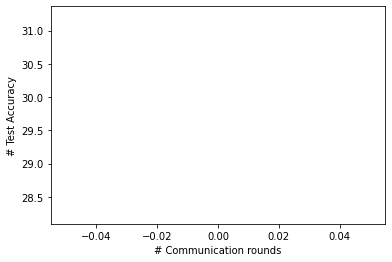

Client  95  has started training with batch size  50  for  20  epochs with learning rate  0.01
Train accuracy at epoch  0  is  10.222222222222221  with loss  2.3088769382900662
Validation accuracy at epoch  0  is  22.0
Train accuracy at epoch  1  is  9.555555555555555  with loss  2.292980511983236
Validation accuracy at epoch  1  is  12.0
Train accuracy at epoch  2  is  17.555555555555557  with loss  2.230973932478163
Validation accuracy at epoch  2  is  22.0
Train accuracy at epoch  3  is  19.77777777777778  with loss  2.129303296407064
Validation accuracy at epoch  3  is  22.0
Train accuracy at epoch  4  is  19.11111111111111  with loss  2.0813543531629772
Validation accuracy at epoch  4  is  24.0
Train accuracy at epoch  5  is  25.333333333333332  with loss  2.0128360324435763
Validation accuracy at epoch  5  is  24.0
Train accuracy at epoch  6  is  25.333333333333332  with loss  1.9690079556571112
Validation accuracy at epoch  6  is  14.000000000000002
Train accuracy at epoch  7  i

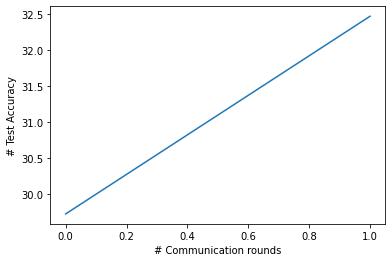

Client  2  has started training with batch size  50  for  20  epochs with learning rate  0.01
Train accuracy at epoch  0  is  8.222222222222221  with loss  2.307750834359063
Validation accuracy at epoch  0  is  8.0
Train accuracy at epoch  1  is  11.777777777777779  with loss  2.286432001325819
Validation accuracy at epoch  1  is  10.0
Train accuracy at epoch  2  is  16.444444444444443  with loss  2.2111300892300076
Validation accuracy at epoch  2  is  18.0
Train accuracy at epoch  3  is  18.0  with loss  2.145266638861762
Validation accuracy at epoch  3  is  20.0
Train accuracy at epoch  4  is  25.11111111111111  with loss  2.0307526191075644
Validation accuracy at epoch  4  is  20.0
Train accuracy at epoch  5  is  21.333333333333332  with loss  2.0391713645723133
Validation accuracy at epoch  5  is  18.0
Train accuracy at epoch  6  is  28.88888888888889  with loss  1.956358790397644
Validation accuracy at epoch  6  is  24.0
Train accuracy at epoch  7  is  28.444444444444443  with los

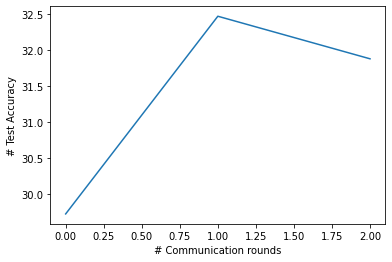

Client  71  has started training with batch size  50  for  20  epochs with learning rate  0.01
Train accuracy at epoch  0  is  9.777777777777779  with loss  2.306116633945041
Validation accuracy at epoch  0  is  12.0
Train accuracy at epoch  1  is  14.0  with loss  2.2787013583713107
Validation accuracy at epoch  1  is  14.000000000000002
Train accuracy at epoch  2  is  17.333333333333332  with loss  2.202611658308241
Validation accuracy at epoch  2  is  20.0
Train accuracy at epoch  3  is  22.0  with loss  2.086601244078742
Validation accuracy at epoch  3  is  22.0
Train accuracy at epoch  4  is  27.555555555555557  with loss  2.0060353411568537
Validation accuracy at epoch  4  is  28.000000000000004
Train accuracy at epoch  5  is  30.0  with loss  1.9473008049858942
Validation accuracy at epoch  5  is  22.0
Train accuracy at epoch  6  is  32.22222222222222  with loss  1.8961759938134088
Validation accuracy at epoch  6  is  30.0
Train accuracy at epoch  7  is  35.333333333333336  with

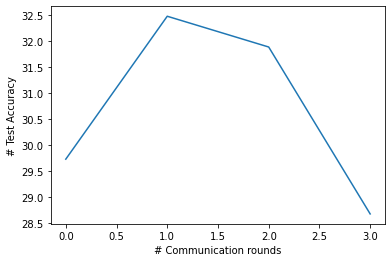

Client  34  has started training with batch size  50  for  20  epochs with learning rate  0.01
Train accuracy at epoch  0  is  11.11111111111111  with loss  2.305903540717231
Validation accuracy at epoch  0  is  4.0
Train accuracy at epoch  1  is  13.555555555555555  with loss  2.2888247966766357
Validation accuracy at epoch  1  is  16.0
Train accuracy at epoch  2  is  17.11111111111111  with loss  2.236490699979994
Validation accuracy at epoch  2  is  8.0
Train accuracy at epoch  3  is  19.333333333333332  with loss  2.160738362206353
Validation accuracy at epoch  3  is  14.000000000000002
Train accuracy at epoch  4  is  23.555555555555557  with loss  2.097932457923889
Validation accuracy at epoch  4  is  14.000000000000002
Train accuracy at epoch  5  is  23.333333333333332  with loss  2.023342397477892
Validation accuracy at epoch  5  is  26.0
Train accuracy at epoch  6  is  28.444444444444443  with loss  1.9416675964991252
Validation accuracy at epoch  6  is  26.0
Train accuracy at 

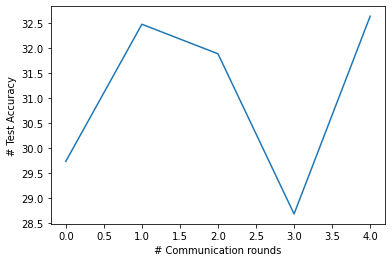

Client  7  has started training with batch size  50  for  20  epochs with learning rate  0.01
Train accuracy at epoch  0  is  10.666666666666666  with loss  2.3108233875698514
Validation accuracy at epoch  0  is  16.0
Train accuracy at epoch  1  is  14.444444444444445  with loss  2.2931942145029702
Validation accuracy at epoch  1  is  24.0
Train accuracy at epoch  2  is  19.77777777777778  with loss  2.1833870146009655
Validation accuracy at epoch  2  is  16.0
Train accuracy at epoch  3  is  19.555555555555557  with loss  2.0773526430130005
Validation accuracy at epoch  3  is  26.0
Train accuracy at epoch  4  is  26.444444444444443  with loss  2.0126602252324424
Validation accuracy at epoch  4  is  28.000000000000004
Train accuracy at epoch  5  is  26.666666666666668  with loss  1.9801079961988661
Validation accuracy at epoch  5  is  28.000000000000004
Train accuracy at epoch  6  is  33.111111111111114  with loss  1.890070531103346
Validation accuracy at epoch  6  is  26.0
Train accura

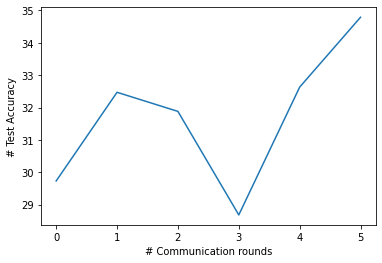

Client  19  has started training with batch size  50  for  20  epochs with learning rate  0.01
Train accuracy at epoch  0  is  10.666666666666666  with loss  2.306655671861437
Validation accuracy at epoch  0  is  2.0
Train accuracy at epoch  1  is  14.0  with loss  2.2955521212683783
Validation accuracy at epoch  1  is  14.000000000000002
Train accuracy at epoch  2  is  22.444444444444443  with loss  2.230621920691596
Validation accuracy at epoch  2  is  18.0


In [ ]:
train_acc_list = []
test_acc_list = []
save_model = "./results/pen_grad_" + str(num_clients) + "," + str(num_epochs) + "," + str(batch_size) + ".sav"

while True:
    turn = np.random.randint(0, num_clients)

    #client train
    print("Client ", turn, " has started training with batch size ", batch_size, " for ", num_epochs, " epochs with learning rate ", lr * (decay**timestamp[turn]))
    local_net = copy.deepcopy(client_models[turn])
    local_net.to(device)
    optimizer = optim.Adam(local_net.parameters())
    # optimizer = optim.SGD(local_net.parameters(), lr = lr * (decay**timestamp[turn]))
    test_accuracy = 0
      
    val_data = torch.utils.data.DataLoader(trainset, batch_size = min(len(vald[turn]),64), sampler = SubsetRandomSampler(vald[turn]))
    for epoch in range(num_epochs):
        # !nvidia-smi
        train_data = torch.utils.data.DataLoader(trainset, batch_size, sampler = SubsetRandomSampler(data[turn]))
        train_accuracy = 0
        running_loss = 0
        for iter, batch in enumerate(train_data):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = local_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            correct_pred = predicted.eq(labels.data).sum().item()
            train_accuracy += (correct_pred/batch_size) * 100
            running_loss += loss.item()
            del outputs, loss        
        val_accuracy = 0
        for iter, batch in enumerate(val_data):
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = local_net(inputs)
          _, predicted = torch.max(outputs.data, 1)
          correct_pred = predicted.eq(labels.data).sum().item()
          val_accuracy += (correct_pred/min(len(vald[turn]),64)) * 100
          del outputs
        
        print("Train accuracy at epoch ", epoch, " is ", train_accuracy * batch_size/len(data[turn]), " with loss ", running_loss * batch_size/len(data[turn]))
        print("Validation accuracy at epoch ", epoch, " is ", val_accuracy * min(len(vald[turn]),64)/len(vald[turn]))
    
    #Update server
    print("Client ", turn, " updates the server!")
    for name, param in avg_model.named_parameters():
        for name2, param2, in local_net.named_parameters():
            if name == name2:
                param.data.copy_(gamma * param.data + (1-gamma) * update_decay**(server_updates - timestamp[turn]) * param2.data)
                
    print("Update decayed by factor" , update_decay**(server_updates - timestamp[turn]))
    
    #TO_DO check whether client models are updating or not
    client_models[turn] = copy.deepcopy(avg_model)
    timestamp[turn] = server_updates
    
    for iter, batch in enumerate(testdata):
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = avg_model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          correct_pred = predicted.eq(labels.data).sum().item()
          test_accuracy += (correct_pred/512) * 100
          del outputs
    print("Current server test accuracy : ", test_accuracy * 512/len(testset))
    print("Increase in server test acc : ", test_accuracy * 512/len(testset) - init_serv_test_acc, " after ", server_updates, " server updates")
    test_acc_list.append(test_accuracy * 512/len(testset))
    fig, ax = plt.subplots()
    ax.set_xlabel('# Communication rounds')
    ax.set_ylabel('# Test Accuracy')
    ax.plot(list(range(server_updates)), test_acc_list)
    save_dir = "./results/pen_grad_" + str(num_clients) + "," + str(num_epochs) + "," + str(batch_size) + ".png"
    plt.savefig(save_dir)
    plt.show()
    server_updates += 1
    pickle.dump(avg_model, open(save_model, 'wb'))

In [ ]:
loader = torch.utils.data.DataLoader(dataset=trainset, batch_size = 64, shuffle=True)
optimizer = optim.Adam(avg_model.parameters())
criterion = nn.CrossEntropyLoss()
for epoch in range(num_epochs):
  for iter, batch in enumerate(loader):
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = avg_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    if iter%20 == 0:
      print("Loss : ", loss.item())

In [ ]:
for iter, batch in enumerate(testdata):
      inputs, labels = batch
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = avg_model(inputs)
      _, predicted = torch.max(outputs.data, 1)
      correct_pred = predicted.eq(labels.data).sum().item()
      test_accuracy += (correct_pred/512) * 100
      del outputs
print("Current server test accuracy : ", test_accuracy * 512/len(testset))
